In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set rng

rng = np.random.RandomState(1984)

In [3]:
# population effects

intercept = -2.
slope = 2.

pop_coefs = np.array([[intercept, slope]])
pop_coefs.shape

(1, 2)

In [4]:
# subject specific effects

num_subjects = 1000

subj_intercepts = rng.randn(num_subjects)
subj_slopes = rng.randn(num_subjects)

In [5]:
# observed features

n_obs_per_subject = rng.randint(1, 50, size=num_subjects)

sid = np.array([i for i, n_obs in enumerate(n_obs_per_subject) for _ in range(n_obs)]).astype(np.int32)
sid_nobs = np.array([n_obs for i, n_obs in enumerate(n_obs_per_subject) for _ in range(n_obs)]).astype(np.int32)

ss_coefs = np.array([
    [c0, c1]
    for n_obs, c0, c1 in zip(n_obs_per_subject, subj_intercepts, subj_slopes)
    for _ in range(n_obs)
])

X = np.stack([np.ones(len(sid)), rng.randn(len(sid))]).T.astype(np.float32)
X.shape, ss_coefs.shape

((24331, 2), (24331, 2))

In [6]:
ss_coefs

array([[-0.02690223, -1.67679307],
       [-0.02690223, -1.67679307],
       [-0.02690223, -1.67679307],
       ...,
       [-1.33373406,  0.04724561],
       [-1.33373406,  0.04724561],
       [-1.33373406,  0.04724561]])

In [7]:
# outcomes

y_logits = np.sum(X * pop_coefs + X * ss_coefs, axis=-1)

def sigmoid(z):
    return 1 / (1 + np.exp(-1 * z))

y_probs = sigmoid(y_logits)
y = (rng.rand(len(y_probs)) < y_probs).astype(np.float32)

y.shape

(24331,)

The overall event rate is 0.23558423


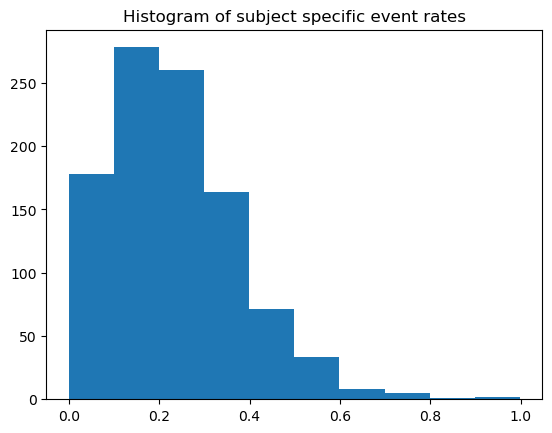

In [8]:
# summary of outcomes

print('The overall event rate is', y.mean())

plt.hist([y_probs[sid == i].mean() for i in range(num_subjects)])
plt.title('Histogram of subject specific event rates')
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
#from torch.utils.data import DataLoader, TensorDataset

# Define the model. Note that 

def normal_nll(x, mu=0., sigma=1.):
    return .5 * ((x - mu) / sigma) ** 2

class NeuralFeaturesGLMM(nn.Module):
    def __init__(self, num_population_effects, num_subjects, num_subject_specific_effects):
        super(NeuralFeaturesGLMM, self).__init__()
        
        self.pop_params_layer = nn.Linear(num_population_effects, 1, bias=False)
        
        self.ss_params_layer = nn.Embedding(num_subjects, num_subject_specific_effects)
        self.ss_params_mu = nn.Parameter(torch.zeros(num_subject_specific_effects, 1))
        self.ss_params_logsigma = nn.Parameter(torch.zeros(num_subject_specific_effects, 1))
        
        self.pop_nll = nn.BCEWithLogitsLoss(reduction='none')
        self.ssp_nll = nn.GaussianNLLLoss(reduction='none')
        
        self.ss_params = self.ss_params_layer.parameters()
        self.pop_params = (*self.pop_params_layer.parameters(), self.ss_params_mu, self.ss_params_logsigma)

    def forward(self, x, z, sid):
        logits = torch.squeeze(self.pop_params_layer(x))
        ss_params = self.ss_params_layer(sid)
        logits += torch.sum(ss_params * z, axis=-1)
        
        return logits
        
    def nll(self, x, z, sid, sid_nobs, y):
        
        y_pred = self.forward(x, z, sid)
        
        # cross entropy loss
        nll = self.pop_nll(y_pred, y)
        
        # subject specific parameters
        ssp = torch.t(self.ss_params_layer(sid))
        
        # subject specific effects likelihood
        # we divide by num obs for each subject to avoid repeating for each observation
        nll += torch.sum(self.ssp_nll(ssp, self.ss_params_mu, torch.exp(self.ss_params_logsigma)), 0) / sid_nobs
        
        return torch.mean(nll)

In [21]:
def get_batches(batch_size=1):
    for ndx in range(0, num_subjects, batch_size):
        idx = (sid >= ndx) & (sid < min(ndx + batch_size, num_subjects))
        yield (torch.from_numpy(arr[idx]) for arr in (X, X, sid, sid_nobs, y))

    
def train(model, epochs, ss_steps=1, pop_steps=1):
    
    ss_opt = optim.Adam(model.ss_params)
    pop_opt = optim.Adam(model.pop_params)
    
    all_loss = []
    
    for epoch in range(epochs):
        
        for batch_idx, (x_batch, z_batch, sid_batch, sid_nobs_batch, y_batch) in enumerate(
            get_batches(batch_size=50)):
            
            #print(x_batch.dtype, sid_batch.dtype, sid_nobs_batch.dtype, y_batch.dtype)
            
            for step in range(ss_steps):
            
                ss_opt.zero_grad()              
                
                loss = model.nll(x_batch, z_batch, sid_batch, sid_nobs_batch, y_batch)
                loss.backward()
                ss_opt.step()
                
            for step in range(pop_steps):
                
                pop_opt.zero_grad()
                
                loss = model.nll(x_batch, z_batch, sid_batch, sid_nobs_batch, y_batch)
                loss.backward()
                pop_opt.step()
                
            current_loss = loss.detach().numpy()
            all_loss.append(current_loss)
            
        print('Epoch %i; Loss = %.3f' % (epoch, current_loss))
        
mdl = NeuralFeaturesGLMM(2, num_subjects, 2)

train(mdl, 100, ss_steps=10)

Epoch 0; Loss = 0.776
Epoch 1; Loss = 0.744
Epoch 2; Loss = 0.715
Epoch 3; Loss = 0.687
Epoch 4; Loss = 0.662
Epoch 5; Loss = 0.639
Epoch 6; Loss = 0.617
Epoch 7; Loss = 0.597
Epoch 8; Loss = 0.578
Epoch 9; Loss = 0.560
Epoch 10; Loss = 0.543
Epoch 11; Loss = 0.528
Epoch 12; Loss = 0.514
Epoch 13; Loss = 0.500
Epoch 14; Loss = 0.487
Epoch 15; Loss = 0.475
Epoch 16; Loss = 0.464
Epoch 17; Loss = 0.453
Epoch 18; Loss = 0.443
Epoch 19; Loss = 0.434
Epoch 20; Loss = 0.425
Epoch 21; Loss = 0.416
Epoch 22; Loss = 0.408
Epoch 23; Loss = 0.401
Epoch 24; Loss = 0.394
Epoch 25; Loss = 0.387
Epoch 26; Loss = 0.380
Epoch 27; Loss = 0.374
Epoch 28; Loss = 0.369
Epoch 29; Loss = 0.363
Epoch 30; Loss = 0.358
Epoch 31; Loss = 0.353
Epoch 32; Loss = 0.348
Epoch 33; Loss = 0.344
Epoch 34; Loss = 0.340
Epoch 35; Loss = 0.336
Epoch 36; Loss = 0.332
Epoch 37; Loss = 0.329
Epoch 38; Loss = 0.325
Epoch 39; Loss = 0.322
Epoch 40; Loss = 0.319
Epoch 41; Loss = 0.316
Epoch 42; Loss = 0.314
Epoch 43; Loss = 0.31

In [22]:
for name, param in mdl.named_parameters():
    if param.requires_grad:
        print(name, param.data)

ss_params_mu tensor([[-0.7629],
        [ 0.6322]])
ss_params_logsigma tensor([[-2.0450],
        [-2.1655]])
pop_params_layer.weight tensor([[-0.8938,  0.9172]])
ss_params_layer.weight tensor([[-0.8830, -0.0214],
        [-1.0658,  0.2641],
        [-0.4545,  0.8598],
        ...,
        [-0.9815,  0.7618],
        [-0.5971,  0.7349],
        [-0.8307,  0.6312]])


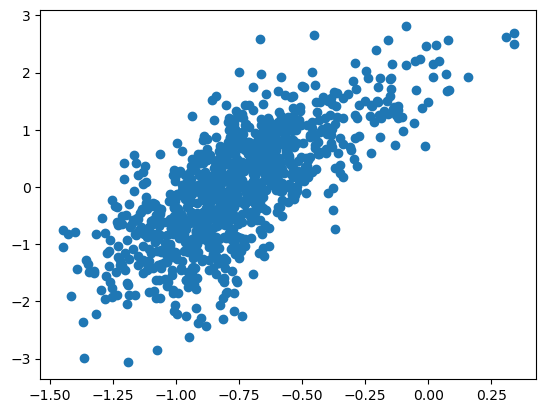

In [29]:
plt.scatter(ss_params_estimated[:, 0], subj_intercepts)
plt.show()

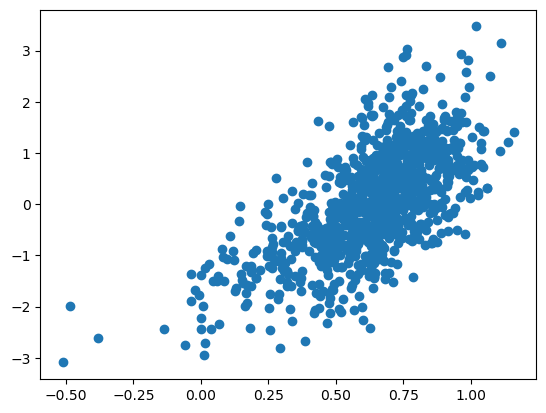

In [30]:
plt.scatter(ss_params_estimated[:, 1], subj_slopes)
plt.show()